In [1]:
import sys, os
if os.path.abspath(os.pardir) not in sys.path:
    sys.path.insert(1, os.path.abspath(os.pardir))
import CONFIG

%reload_ext autoreload
%autoreload 2

In [2]:
from IPython.display import Image

import pandas as pd
import numpy as np
import cv2
import os, re

import torch

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import DataLoader, Dataset

from matplotlib import pyplot as plt 
plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [3]:
DATA_DIR = CONFIG.CFG.DATA.BASE
MODELS_OUT_DIR = CONFIG.CFG.DATA.MODELS_OUT
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
ON_CPU = DEVICE == torch.device('cpu')
TRAIN_BATCH_SIZE = 4 if ON_CPU else 16
VALID_BATCH_SIZE = 4 if ON_CPU else 6
NUM_EPOCHS = 5 if ON_CPU else 20
NEW_COLUMNS = ['x', 'y', 'w', 'h']

train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

UNIQ_TRAIN_IMAGE_IDS = train_df["image_id"].unique()

train_df.shape, test_df.shape

((147793, 5), (10, 2))

In [4]:
# expand the bbox coordinates into x, y, w, h
def expand_bbox(x):
    # also convert everything to np.float
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x), dtype=np.float)
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

# initialize new columns with -1
for new_column in NEW_COLUMNS:
    train_df[new_column] = -1

train_df[NEW_COLUMNS] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [5]:
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    assert image is not None, f"IMAGE NOT FOUND AT {image_path}"
    return image

In [6]:
def draw_bboxes(boxes, image, color=(255,0,0)):
    for box in boxes:
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 3
        )
    return image

In [7]:
def plot_random_train_sample():
    image_id = np.random.choice(UNIQ_TRAIN_IMAGE_IDS)
    plt.title(image_id)
    image = load_image(os.path.join(DATA_DIR, "train", f"{image_id}.jpg"))
    bboxes = (train_df[train_df["image_id"] == image_id][NEW_COLUMNS]).to_numpy()
    bboxes[:, 2] = bboxes[:, 0] + bboxes[:, 2]
    bboxes[:, 3] = bboxes[:, 1] + bboxes[:, 3]
    plt.imshow(draw_bboxes(bboxes, image))

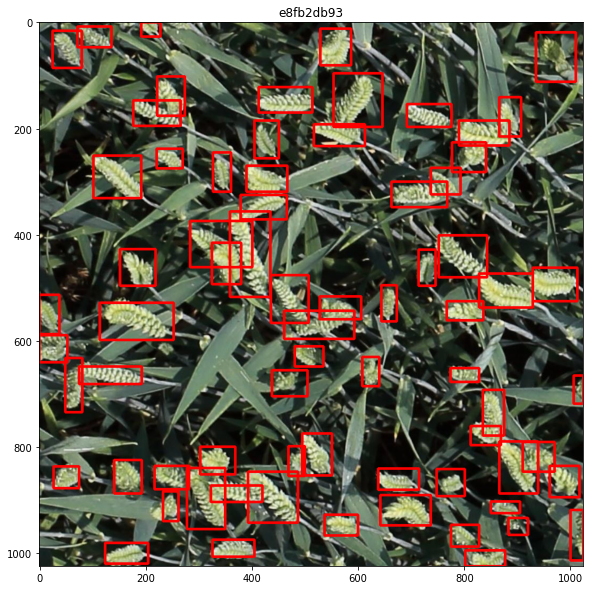

In [8]:
plot_random_train_sample()

In [9]:
class WheatDataset(Dataset):
    def __init__(self, df, image_dir, transforms=None):
        super().__init__()

        self.df = df
        self.image_dir = image_dir
        self.transforms = transforms
        self.image_ids = df['image_id'].unique()

    def __len__(self) -> int:
        return len(self.image_ids)

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        image = load_image(os.path.join(self.image_dir, f"{image_id}.jpg")).astype(np.float32)
        image /= 255.0
        # change the shape from [h,w,c] to [c,h,w]  
        image = torch.from_numpy(image).permute(2,0,1)

        records = self.df[self.df['image_id'] == image_id]

        boxes = records[NEW_COLUMNS].values
        area = boxes[:, 2] * boxes[:, 3]
        area = torch.as_tensor(area, dtype=torch.float32)

        # change the co-ordinates into expected [x, y, x+w, y+h] format
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # since all the boxes are wheat, it's all 1s
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        # consider iscrowd false for all the boxes
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms:
            pass

        return image, target

In [10]:
def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # replace the end predictor with new FastRCNNPredictor with 2 classes (background(0) + wheat(1) (background is always 0))
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features, num_classes=2)
    return model

In [11]:
# 10% into validation
n_validation = int(0.1* len(UNIQ_TRAIN_IMAGE_IDS))
valid_ids = UNIQ_TRAIN_IMAGE_IDS[-n_validation:]
train_ids = UNIQ_TRAIN_IMAGE_IDS[:-n_validation]

df_in_valid = train_df[train_df['image_id'].isin(valid_ids)]
df_in_train = train_df[train_df['image_id'].isin(train_ids)]

print("%i training samples\n%i validation samples" % (len(df_in_train["image_id"].unique()), len(df_in_valid["image_id"].unique())))

3036 training samples
337 validation samples


In [12]:
train_dataset = WheatDataset(df_in_train, os.path.join(DATA_DIR, "train"))
valid_dataset = WheatDataset(df_in_valid, os.path.join(DATA_DIR, "train"))

# since our single getitem returns image, targets. [shape of targets is different depending on the number of bounding boxes in the image] ?
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


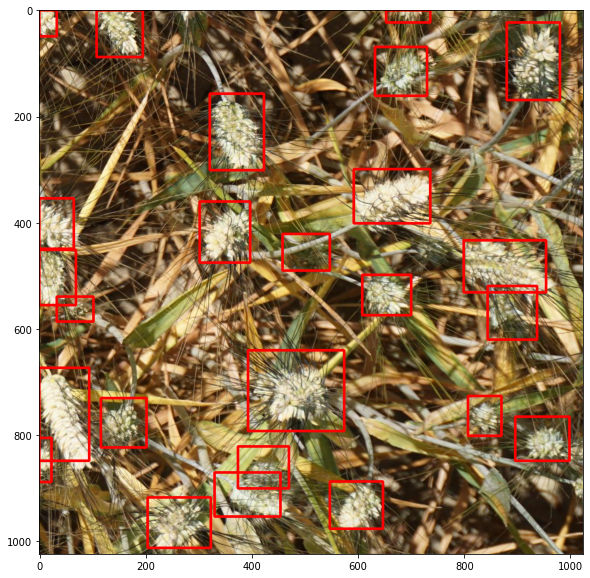

In [13]:
# check the batch is working
batch_of_images, batch_of_targets = next(iter(train_data_loader))
sample_boxes = batch_of_targets[0]['boxes'].cpu().numpy().astype(np.int32)
# convert to normal image format
sample_image = batch_of_images[0].permute(1,2,0).cpu().numpy()
plt.imshow(draw_bboxes(sample_boxes, sample_image))

In [14]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [15]:
model = get_model()
model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
train_losses = Averager()
val_losses = Averager()
lowest_val_loss = float('inf')

# has to be in train mode for both train and valid coz the outputs are different in two cases
model.train()
for epoch in range(NUM_EPOCHS):
    train_losses.reset()
    val_losses.reset()

    for batch_index, (images, targets) in enumerate(train_data_loader):
        # move the images and targets to device
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images,targets)
        loss = sum(loss for loss in loss_dict.values())

        # track the loss
        train_losses.send(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 50 == 0:
            print(f"Epoch: {epoch} Batch Index: {batch_index} Loss: {loss.item()}")

    # evaluate
    for _, (images, targets) in enumerate(valid_data_loader):
        # move the images and targets to device
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        val_loss_dict = model(images, targets)
        val_loss = sum(loss for loss in val_loss_dict.values())

        # track the loss
        val_losses.send(val_loss.item())

    if val_losses.value < lowest_val_loss:
        torch.save(model.state_dict(), os.path.join(MODELS_OUT_DIR, "best_model.pth"))
    else:
        if lr_scheduler is not None:
            lr_scheduler.step()
    
    # print stats
    print(f"Epoch #{epoch} TRAIN LOSS: {train_losses.value} VALIDATION LOSS: {val_losses.value}\n")


In [ ]:
torch.save(model.state_dict(), os.path.join(MODELS_OUT_DIR, 'simple_fastercnn.pth'))

In [ ]:
CONFIG.upload_to_kaggle("wheatfastercnn", "Simple Faster R-CNN")